In [1]:
import os
import re
import nltk
import spacy
import random
import neuralcoref
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [2]:
wnl = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [3]:
nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp)

# The SMMRY Algorithm

In [4]:
transition_phrases = ['thus', 'for example', 'for instance', 'namely', 'to illustrate',
                      'in other words', 'in particular', 'specifically', 'such as',
                      'on the contrary', 'contrarily', 'notwithstanding', 'but', 'however',
                      'nevertheless', 'in spite of', 'in contrast', 'yet', 'on one hand',
                      'on the other hand', 'rather', 'or', 'nor', 'conversely', 'at the same time',
                      'while this may be true', 'and', 'in addition to', 'furthermore',
                      'moreover', 'besides', 'than', 'too', 'also', 'both-and', 'another',
                      'equally important', 'second', 'etc.', 'again', 'further', 'last',
                      'finally', 'not only-but also', 'as well as', 'in the second place',
                      'next', 'likewise', 'similarly', 'in fact', 'as a result', 'consequently',
                      'in the same way', 'for example', 'for instance', 'however', 'thus',
                      'therefore', 'otherwise', 'after that', 'afterward', 'then', 'next',
                      'last', 'at last', 'at length', 'at first', 'formerly', 'another', 'finally',
                      'meanwhile', 'at the same time', 'afterwards', 'subsequently',
                      'in the meantime', 'eventually', 'concurrently', 'simultaneously', 'although',
                      'at least', 'still', 'even though', 'granted that', 'while it may be true',
                      'in spite of', 'of course', 'similarly', 'likewise', 'in like fashion',
                      'in like manner', 'analogous to', 'above all', 'indeed', 'of course',
                      'certainly', 'surely', 'in fact', 'really', 'in truth', 'again', 'besides',
                      'also', 'furthermore', 'in addition', 'specifically', 'especially',
                      'in particular', 'to explain', 'to list', 'to enumerate', 'in detail',
                      'namely', 'including', 'for example', 'for instance', 'to illustrate',
                      'thus', 'in other words', 'as an illustration', 'in particular', 'so that',
                      'with the result that', 'consequently', 'hence', 'accordingly', 'for this reason',
                      'therefore', 'because', 'due to', 'as a result', 'in other words', 'then',
                      'therefore', 'finally', 'consequently', 'thus', 'in conclusion', 'as a result',
                      'accordingly', 'for this purpose', 'to this end', 'with this in mind',
                      'with this purpose in mind', 'therefore']

In [5]:
def transition_start(first_sent, dialog_turn):
    if dialog_turn == 1:
        for phrase in transition_phrases:
            if first_sent.lower().startswith(phrase):
                return True
        return False
    else:
        return False

In [6]:
def smmry(text, doc, sent_count, dialog_turn):

    # some preprocessing to omit text within brackets and replace u with you. 
    
    # text = re.sub("[\(\[].*?[\)\]]", "", text)
    # text = text.replace(' u ', ' you ')

    formatted_text = re.sub('[^a-zA-Z]', ' ', text)
    formatted_text = re.sub(r'\s+', ' ', formatted_text)

    # doc = nlp(text)

    fdist = {}
    word_arr = nltk.word_tokenize(formatted_text.lower())

    # preparing a frequency dictionary without considering stop words
    
    for word in word_arr:
        if not word in stop_words:
            word = wnl.lemmatize(word)
            if word not in fdist.keys():
                    fdist[word] = 1
            else:
                    fdist[word] += 1

    sent_arr = nltk.sent_tokenize(text)
    sent_score_arr = []
    summary_arr = []

    sent_arr_coref_resolved = nltk.sent_tokenize(doc._.coref_resolved)

    # compute scores for each sentence

    for sent in sent_arr:
        score = 0
        token_arr = nltk.word_tokenize(sent.lower())
        for word in token_arr:
            word = wnl.lemmatize(word)
            if word in fdist.keys():
                score += fdist[word]

        sent_score_arr.append(score/len(token_arr))

    sent_score_arr = np.array(sent_score_arr)

    all_ind_arr = sent_score_arr.argsort()[-len(sent_score_arr):][::-1]

    ind_arr_unsorted = sent_score_arr.argsort()[-sent_count:][::-1]

    ind_arr = np.sort(ind_arr_unsorted) 

    summary = ''
    changed_first = False

    if len(ind_arr) > 0:

        try:

            ind = ind_arr[0]
            first_sent = sent_arr[ind]

            while (first_sent != sent_arr_coref_resolved[ind] or transition_start(first_sent, dialog_turn)):
                changed_first = True
                for index in all_ind_arr:
                    if index < ind:
                        ind = index
                        break
                first_sent = sent_arr[ind]
                if ind == 0:
                    break
            summary = summary + first_sent + ' '     
            
            if (changed_first):
                first_ind = ind
                sent_score_modified = sent_score_arr[first_ind+1:]
                ind_arr_unsorted = sent_score_modified.argsort()[-(sent_count-1):][::-1]
                ind_arr_next = np.sort(ind_arr_unsorted) 
                
                for i in range(0, len(ind_arr_next)):
                    ind = (first_ind+1) + ind_arr_next[i]
                    if i == len(ind_arr_next) - 1:
                        summary = summary + sent_arr[ind]
                    else:
                        summary = summary + sent_arr[ind] + ' '
            
            else:
                for i in range(1, len(ind_arr)):
                    ind = ind_arr[i]
                    if i == len(ind_arr) - 1:
                        summary = summary + sent_arr[ind]
                    else:
                        summary = summary + sent_arr[ind] + ' '

            return summary

        except Exception as e:

            print("EXCEPTION occured")
            return text

    else:
        print(text)
        print(sent_arr)
        print("EXCEPTION occured: length of sentence array is not > 0")
        return text

# Data Cleaning Functions

In [7]:
# aux_verbs = ['be', 'can', 'could', 'dare', 'do', 'have', 'may', 'might', 'must',
#              'need', 'ought', 'shall', 'should', 'will', 'would']
# wh_words = ['what', 'when', 'where', 'which', 'who', 'whom', 'whose', 'why', 'how']
# q_words = aux_verbs + wh_words

In [8]:
def preprocess_raw(text):
    # Check if text is a str
    if not isinstance(text, str):
        return None

    # Replace HTML escape chars
    text = text.replace('&gt;', '>')
    text = text.replace('&lt;', '<')
    text = text.replace('&amp;', '&')
    text = text.replace('#x200B;', ' ')
    text = text.replace('nbsp;', ' ')

    # Remove brackets
    b_pattern = re.compile(r'(\([^\(\)]*\))|(\[[^\[\]]*\])')
    while b_pattern.search(text):
        text = re.sub(r'(\([^\(\)]*\))|(\[[^\[\]]*\])', '', text)

    # Remove redundant spaces (including breaklines)
    text = ' '.join(text.split())

    # Check if text is empty
    if not text:
        return None

    text_lower = text.lower()

    # Check if text is [deleted] or [removed]
    if text_lower == '[deleted]' or text_lower == '[removed]':
        return None

    # Check if text contains URL
    url_pattern = re.compile(r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
    if url_pattern.search(text_lower):
        return None

    # Check if text contains 'r/<subreddit>' or 'u/<username>'
    r_pattern = re.compile(r'(^| )\/?r\/[^ ]*')
    if r_pattern.search(text_lower):
        return None
    u_pattern = re.compile(r'(^| )\/?u\/[^ ]*')
    if u_pattern.search(text_lower):
        return None

    # Check if text contains 'reddit'
    if 'reddit' in text_lower:
        return None

    # Check the percentage of alphabetical letters
    num_alphas = 0
    for ch in text:
        if ch.isalpha():
            num_alphas += 1
    if num_alphas / len(text) < 0.7:
        return None

    doc = nlp(text)

    # Check the number of tokens
    if len(doc) < 2:
        return None

    return {'text': text, 'doc': doc}

In [9]:
def preprocess_summary(text):
    # Check if text is a str
    if not isinstance(text, str):
        return None

    # Remove redundant spaces (including breaklines)
    text = ' '.join(text.split())

    # Check if text is empty
    if not text:
        return None

    # Check the percentage of alphabetical letters
    num_alphas = 0
    for ch in text:
        if ch.isalpha():
            num_alphas += 1
    if num_alphas / len(text) < 0.7:
        return None

    doc = nlp(text)

    # Check the number of tokens
    if len(doc) < 2:
        return None

    return {'text': text, 'doc': doc}

In [10]:
def extract_root(text, sent):
#     # Check if the last character is a question mark
#     if sent[-1].text == '?':
#         return None

    if sent.root.pos_ == 'VERB':
#         # Check the first token
#         if sent[0].lemma_.lower() in q_words:
#             return None
        return sent.root.lemma_

    return None

In [11]:
def summarize(preprocessed_text, dialog_turn):
    if preprocessed_text is None:
        return None

    text = preprocessed_text['text']
    doc = preprocessed_text['doc']

    summarized = 0
    sents = [sent for sent in doc.sents]
    if len(sents) > 1:
        summarized = 1
        summary = smmry(text, doc, 1, dialog_turn)
        preprocessed_summary = preprocess_summary(summary)
        if preprocessed_summary is None:
            return None
        summarized_text = preprocessed_summary['text']
        summarized_doc = preprocessed_summary['doc']
        summarized_sents = [sent for sent in summarized_doc.sents]
        if len(summarized_sents) != 1:
            return None
    elif len(sents) == 1:
        summarized_text = text
        summarized_doc = doc
        summarized_sents = sents
    else:
        return None

    if dialog_turn > 1:
        return {'text': summarized_text, 'summarized': summarized, 'length': len(summarized_sents[0])}

    root = extract_root(summarized_text, summarized_sents[0])
    if root is not None:
        return {'text': summarized_text, 'summarized': summarized, 'root': root, 'length': len(summarized_sents[0])}
    else:
        return None

# Filter the ED Dialogs

In [13]:
df_train = pd.read_csv('../data/ed/raw/train.csv')

In [14]:
df_train

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN
...,...,...,...,...,...,...,...,...
84164,hit:12424_conv:24848,5,sentimental,I found some pictures of my grandma in the att...,389,Yeah reminds me of the good old days. I miss ...,5|5|5_5|5|5,NaN
84165,hit:12424_conv:24849,1,surprised,I woke up this morning to my wife telling me s...,294,I woke up this morning to my wife telling me s...,5|5|5_5|5|5,NaN
84166,hit:12424_conv:24849,2,surprised,I woke up this morning to my wife telling me s...,389,Oh hey that's awesome! That is awesome right?,5|5|5_5|5|5,NaN
84167,hit:12424_conv:24849,3,surprised,I woke up this morning to my wife telling me s...,294,It is soooo awesome. We have been wanting a b...,5|5|5_5|5|5,NaN


In [15]:
first_turn_cols = ['id', 'summarized', 'text', 'root', 'length', 'emotion']
first_turn_dict = {col: [] for col in first_turn_cols}
second_turn_cols = ['id', 'summarized', 'text', 'length']
second_turn_dict = {col: [] for col in second_turn_cols}

In [16]:
def filter_ed(csv_file_path):
    df = pd.read_csv(csv_file_path)
    for i in tqdm(range(df.shape[0])):
        conv_id = df.iloc[i]['conv_id']
        emotion = df.iloc[i]['context']
        uttr_idx = df.iloc[i]['utterance_idx']
        uttr = df.iloc[i]['utterance'].replace('_comma_', ',')
        if uttr_idx == 1:
            preprocessed_uttr = preprocess_raw(uttr)
            summarized_uttr = summarize(preprocessed_uttr, dialog_turn = 1)
            if summarized_uttr is not None:
                first_turn_dict['id'].append(conv_id + '_uttr:1')
                first_turn_dict['summarized'].append(summarized_uttr['summarized'])
                first_turn_dict['text'].append(summarized_uttr['text'])
                first_turn_dict['root'].append(summarized_uttr['root'])
                first_turn_dict['length'].append(summarized_uttr['length'])
                first_turn_dict['emotion'].append(emotion)
        elif uttr_idx == 2:
            preprocessed_uttr = preprocess_raw(uttr)
            summarized_uttr = summarize(preprocessed_uttr, dialog_turn = 2)
            if summarized_uttr is not None:
                second_turn_dict['id'].append(conv_id + '_uttr:2')
                second_turn_dict['summarized'].append(summarized_uttr['summarized'])
                second_turn_dict['text'].append(summarized_uttr['text'])
                second_turn_dict['length'].append(summarized_uttr['length'])

In [17]:
filter_ed('../data/ed/raw/train.csv')

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊            | 74538/84169 [06:11<00:52, 183.88it/s]

EXCEPTION occured


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 84169/84169 [06:59<00:00, 200.76it/s]


In [18]:
filter_ed('../data/ed/raw/valid.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 12078/12078 [01:00<00:00, 199.09it/s]


In [19]:
filter_ed('../data/ed/raw/test.csv')

 32%|█████████████████████████████████▋                                                                         | 3425/10869 [00:18<00:43, 170.23it/s]

EXCEPTION occured


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10869/10869 [00:57<00:00, 188.58it/s]


In [20]:
first_turn_df = pd.DataFrame(first_turn_dict)

In [21]:
first_turn_df

,id,summarized,text,root,length,emotion
0,hit:1_conv:2_uttr:1,0,it feels like hitting to blank wall when i see...,feel,12,afraid
1,hit:2_conv:4_uttr:1,0,I have never cheated on my wife.,cheat,8,faithful
2,hit:2_conv:5_uttr:1,0,"Job interviews always make me sweat bullets, m...",make,23,terrified
3,hit:4_conv:8_uttr:1,0,I lost my job last year and got really angry.,lose,11,angry
4,hit:5_conv:11_uttr:1,0,"My coworker is allowed to work remotely, but I...",allow,13,jealous
...,...,...,...,...,...,...
14839,hit:12384_conv:24768_uttr:1,0,"I almost got caught stealing, I felt pretty bad",feel,10,ashamed
14840,hit:12390_conv:24781_uttr:1,0,Some random dude walked into my room while I w...,walk,19,afraid
14841,hit:12391_conv:24783_uttr:1,0,Someone hit my car at walmart today and drove ...,hit,11,furious
14842,hit:12398_conv:24797_uttr:1,1,I saw my favourite candy at the store today!,see,10,nostalgic


In [22]:
second_turn_df = pd.DataFrame(second_turn_dict)

In [23]:
second_turn_df

,id,summarized,text,length
0,hit:0_conv:1_uttr:2,0,"Was this a friend you were in love with, or ju...",16
1,hit:2_conv:4_uttr:2,0,"And thats something you should never do, good ...",13
2,hit:2_conv:5_uttr:2,1,Just be prepared.,4
3,hit:3_conv:7_uttr:2,1,Sounds great!,3
4,hit:4_conv:8_uttr:2,1,I am sorry to hear that.,7
...,...,...,...,...
22156,hit:12409_conv:24818_uttr:2,0,What had he made in the world?,8
22157,hit:12411_conv:24823_uttr:2,1,I hope everything is alright.,6
22158,hit:12413_conv:24826_uttr:2,0,that is a great way to look at it,9
22159,hit:12416_conv:24832_uttr:2,0,did you call the exterminator?,6


In [24]:
second_turn_ids = second_turn_df['id'].tolist()
first_turn_ids = [x[:-1] + '1' for x in second_turn_ids]
first_turn_df_final = first_turn_df[first_turn_df['id'].isin(first_turn_ids)]
first_turn_df_final

,id,summarized,text,root,length,emotion
1,hit:2_conv:4_uttr:1,0,I have never cheated on my wife.,cheat,8,faithful
2,hit:2_conv:5_uttr:1,0,"Job interviews always make me sweat bullets, m...",make,23,terrified
3,hit:4_conv:8_uttr:1,0,I lost my job last year and got really angry.,lose,11,angry
4,hit:5_conv:11_uttr:1,0,"My coworker is allowed to work remotely, but I...",allow,13,jealous
5,hit:7_conv:14_uttr:1,1,A man came to me from behind giving me back my...,come,13,grateful
...,...,...,...,...,...,...
14838,hit:12318_conv:24637_uttr:1,0,"I don't like scammy sales people, nothing good...",come,13,furious
14839,hit:12384_conv:24768_uttr:1,0,"I almost got caught stealing, I felt pretty bad",feel,10,ashamed
14840,hit:12390_conv:24781_uttr:1,0,Some random dude walked into my room while I w...,walk,19,afraid
14842,hit:12398_conv:24797_uttr:1,1,I saw my favourite candy at the store today!,see,10,nostalgic


In [25]:
first_turn_df_final.to_csv('../data/ed/filtered_q/ed_first_turns.csv', index = False)

In [26]:
first_turn_ids = first_turn_df['id'].tolist()
second_turn_ids = [x[:-1] + '2' for x in first_turn_ids]
second_turn_df_final = second_turn_df[second_turn_df['id'].isin(second_turn_ids)]
second_turn_df_final

,id,summarized,text,length
1,hit:2_conv:4_uttr:2,0,"And thats something you should never do, good ...",13
2,hit:2_conv:5_uttr:2,1,Just be prepared.,4
4,hit:4_conv:8_uttr:2,1,I am sorry to hear that.,7
5,hit:5_conv:11_uttr:2,0,"I work remotely, I wish that you could do some...",16
6,hit:7_conv:14_uttr:2,0,"Thats a sweet man, I hope you acknowledged his...",14
...,...,...,...,...
22141,hit:12318_conv:24637_uttr:2,0,"I agree, were you recently screwed by one?",10
22151,hit:12384_conv:24768_uttr:2,1,Ouch!,2
22153,hit:12390_conv:24781_uttr:2,1,Oh wow that is weird.,6
22154,hit:12398_conv:24797_uttr:2,1,Oh nice.,3


In [27]:
second_turn_df_final.to_csv('../data/ed/filtered_q/ed_second_turns.csv', index = False)

# Gather All Data

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

## Plot Histograms

In [3]:
all_posts_df = pd.read_csv('../data/merged_q/all_posts.csv')
all_posts_df.head()

,id,summarized,text,root,length
0,r2wyka,0,Can you learn to be less afraid?,learn,8
1,r2woiu,1,Do you like persons with a little edge to them?,like,11
2,r2wc2q,0,"Why doesn't Activia use the word ""yogurt"" on t...",use,14
3,r2w43k,0,Do you ever feel like everyone else has it tog...,feel,13
4,r2vbm3,0,Does pressing keyboard keys reflect your perso...,reflect,8


Min = 2
Max = 105
Mean = 11.84353245332413
Median = 10.0


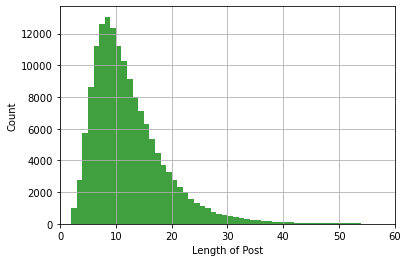

In [28]:
lens = all_posts_df['length'].tolist()
print('Min = {}'.format(min(lens)))
print('Max = {}'.format(max(lens)))
print('Mean = {}'.format(np.mean(lens)))
print('Median = {}'.format(np.median(lens)))

n, bins, patches = plt.hist(lens, range(60), facecolor='g', alpha=0.75)

plt.xlabel('Length of Post')
plt.ylabel('Count')
plt.xlim(0, 60)
plt.grid(True)
plt.show()

In [5]:
all_replies_df = pd.read_csv('../data/merged_q/all_replies.csv')
all_replies_df.head()

,id,parent_id,summarized,text,length
0,hm5iqwj,r2nmvy,1,Conscious Club is campy in a good way,8
1,hm5jftd,r2npa3,0,I take one to two hours a day where I listen t...,24
2,hm5kaqv,r2nmvy,0,I like Scary Pockets.,5
3,hm5kddu,r2nylj,0,what keeps me calm is my prescription medication,8
4,hm5kig9,r2nylj,1,Wow you're amazingly talented.,6


Min = 2
Max = 360
Mean = 11.509432207808716
Median = 9.0


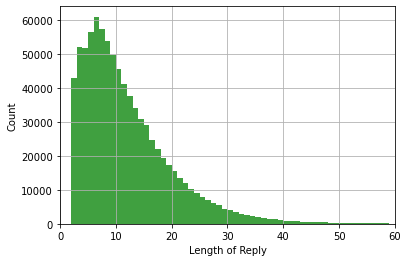

In [29]:
lens = all_replies_df['length'].tolist()
print('Min = {}'.format(min(lens)))
print('Max = {}'.format(max(lens)))
print('Mean = {}'.format(np.mean(lens)))
print('Median = {}'.format(np.median(lens)))

n, bins, patches = plt.hist(lens, range(60), facecolor='g', alpha=0.75)

plt.xlabel('Length of Reply')
plt.ylabel('Count')
plt.xlim(0, 60)
plt.grid(True)
plt.show()

## Gather Data

In [12]:
all_posts_cols = ['id', 'summarized', 'text', 'root', 'length']
all_posts_dict = {col: [] for col in all_posts_cols}
all_replies_cols = ['id', 'parent_id', 'summarized', 'text', 'length']
all_replies_dict = {col: [] for col in all_replies_cols}

### Gather Reddit Data

In [13]:
max_len = 40

In [14]:
date_suffices = [
    '20210501_20211231',
    '20210101_20210430',
    '20200101_20201231',
    '20190101_20191231',
    '20180101_20181231',
    '20170101_20171231',
    '20160101_20161231'
]

In [15]:
for date_suffix in tqdm(date_suffices):
    comment_df = pd.read_csv('../data/reddit/filtered_q/casual_conv_comments_{}.csv'.format(date_suffix))
    submission_df = pd.read_csv('../data/reddit/filtered_q/casual_conv_submissions_{}.csv'.format(date_suffix))

    comment_df = comment_df[comment_df['length'] <= max_len]
    submission_df = submission_df[submission_df['length'] <= max_len]

    comment_parent_ids = comment_df['parent_id'].tolist()
    comment_parent_ids = [x[3:] for x in comment_parent_ids]
    submission_df_final = submission_df[submission_df['id'].isin(comment_parent_ids)]

    submission_ids = submission_df_final['id'].tolist()
    submission_ids = ['t3_' + x for x in submission_ids]
    comment_df_final = comment_df[comment_df['parent_id'].isin(submission_ids)]

    for col in all_posts_cols:
        all_posts_dict[col] += submission_df_final[col].tolist()
    for col in all_replies_cols:
        if col != 'parent_id':
            all_replies_dict[col] += comment_df_final[col].tolist()
    all_replies_dict['parent_id'] += [x[3:] for x in comment_df_final['parent_id'].tolist()]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.15it/s]


### Gather ED Data

In [16]:
ed_first_turn_df = pd.read_csv('../data/ed/filtered_q/ed_first_turns.csv')
ed_second_turn_df = pd.read_csv('../data/ed/filtered_q/ed_second_turns.csv')

ed_second_turn_df = ed_second_turn_df[ed_second_turn_df['length'] <= max_len]
ed_first_turn_df = ed_first_turn_df[ed_first_turn_df['length'] <= max_len]

ed_second_turn_ids = ed_second_turn_df['id'].tolist()
ed_first_turn_ids = [x[:-1] + '1' for x in ed_second_turn_ids]
ed_first_turn_df_final = ed_first_turn_df[ed_first_turn_df['id'].isin(ed_first_turn_ids)]

ed_first_turn_ids = ed_first_turn_df['id'].tolist()
ed_second_turn_ids = [x[:-1] + '2' for x in ed_first_turn_ids]
ed_second_turn_df_final = ed_second_turn_df[ed_second_turn_df['id'].isin(ed_second_turn_ids)]

assert ed_first_turn_df_final.shape[0] == ed_second_turn_df_final.shape[0]

for col in all_posts_cols:
    all_posts_dict[col] += ed_first_turn_df_final[col].tolist()
for col in all_replies_cols:
    if col != 'parent_id':
        all_replies_dict[col] += ed_second_turn_df_final[col].tolist()
all_replies_dict['parent_id'] += ed_first_turn_df_final['id'].tolist()

In [17]:
all_posts_df = pd.DataFrame(all_posts_dict)
all_posts_df

,id,summarized,text,root,length
0,r2wyka,0,Can you learn to be less afraid?,learn,8
1,r2wc2q,0,"Why doesn't Activia use the word ""yogurt"" on t...",use,14
2,r2w43k,0,Do you ever feel like everyone else has it tog...,feel,13
3,r2vbm3,0,Does pressing keyboard keys reflect your perso...,reflect,8
4,r2v7x0,0,My boss told me that during the time my hair w...,make,21
...,...,...,...,...,...
152675,hit:12318_conv:24637_uttr:1,0,"I don't like scammy sales people, nothing good...",come,13
152676,hit:12384_conv:24768_uttr:1,0,"I almost got caught stealing, I felt pretty bad",feel,10
152677,hit:12390_conv:24781_uttr:1,0,Some random dude walked into my room while I w...,walk,19
152678,hit:12398_conv:24797_uttr:1,1,I saw my favourite candy at the store today!,see,10


In [18]:
all_replies_df = pd.DataFrame(all_replies_dict)
all_replies_df

,id,parent_id,summarized,text,length
0,hm5iqwj,r2nmvy,1,Conscious Club is campy in a good way,8
1,hm5jftd,r2npa3,0,I take one to two hours a day where I listen t...,24
2,hm5kaqv,r2nmvy,0,I like Scary Pockets.,5
3,hm5kddu,r2nylj,0,what keeps me calm is my prescription medication,8
4,hm5kig9,r2nylj,1,Wow you're amazingly talented.,6
...,...,...,...,...,...
838780,hit:12318_conv:24637_uttr:2,hit:12318_conv:24637_uttr:1,0,"I agree, were you recently screwed by one?",10
838781,hit:12384_conv:24768_uttr:2,hit:12384_conv:24768_uttr:1,1,Ouch!,2
838782,hit:12390_conv:24781_uttr:2,hit:12390_conv:24781_uttr:1,1,Oh wow that is weird.,6
838783,hit:12398_conv:24797_uttr:2,hit:12398_conv:24797_uttr:1,1,Oh nice.,3


In [21]:
N_posts = all_posts_df.shape[0]
N_replies = all_replies_df.shape[0]
print(N_posts*N_posts*32/8/1024/1024/1024)
print(N_replies*N_replies*32/8/1024/1024/1024)

86.84092164039612
2620.966271404177


In [29]:
print(len(set(all_posts_df['id'].tolist())))

65017


In [30]:
print(len(set(all_replies_df['parent_id'].tolist())))

65017


In [31]:
'n1sfco' in set(all_posts_df['id'].tolist())

True

In [32]:
all_posts_df.to_csv('../data/merged_q/all_posts_max_len_10.csv', index = False)
all_replies_df.to_csv('../data/merged_q/all_replies_max_len_10.csv', index = False)